# 조합 최적화
- combinatorial optimization
- 업무 배정 문제 (assignment problem)
- 아래에서 숫자는 업무를 배정하는 비용을 나타낸다
- 최적의 업무 배정 방법을 찾는 것 (비용의 합이 최소화가 되도록 배정)
- MIP 와 CP-SAT solver를 사용하겠다

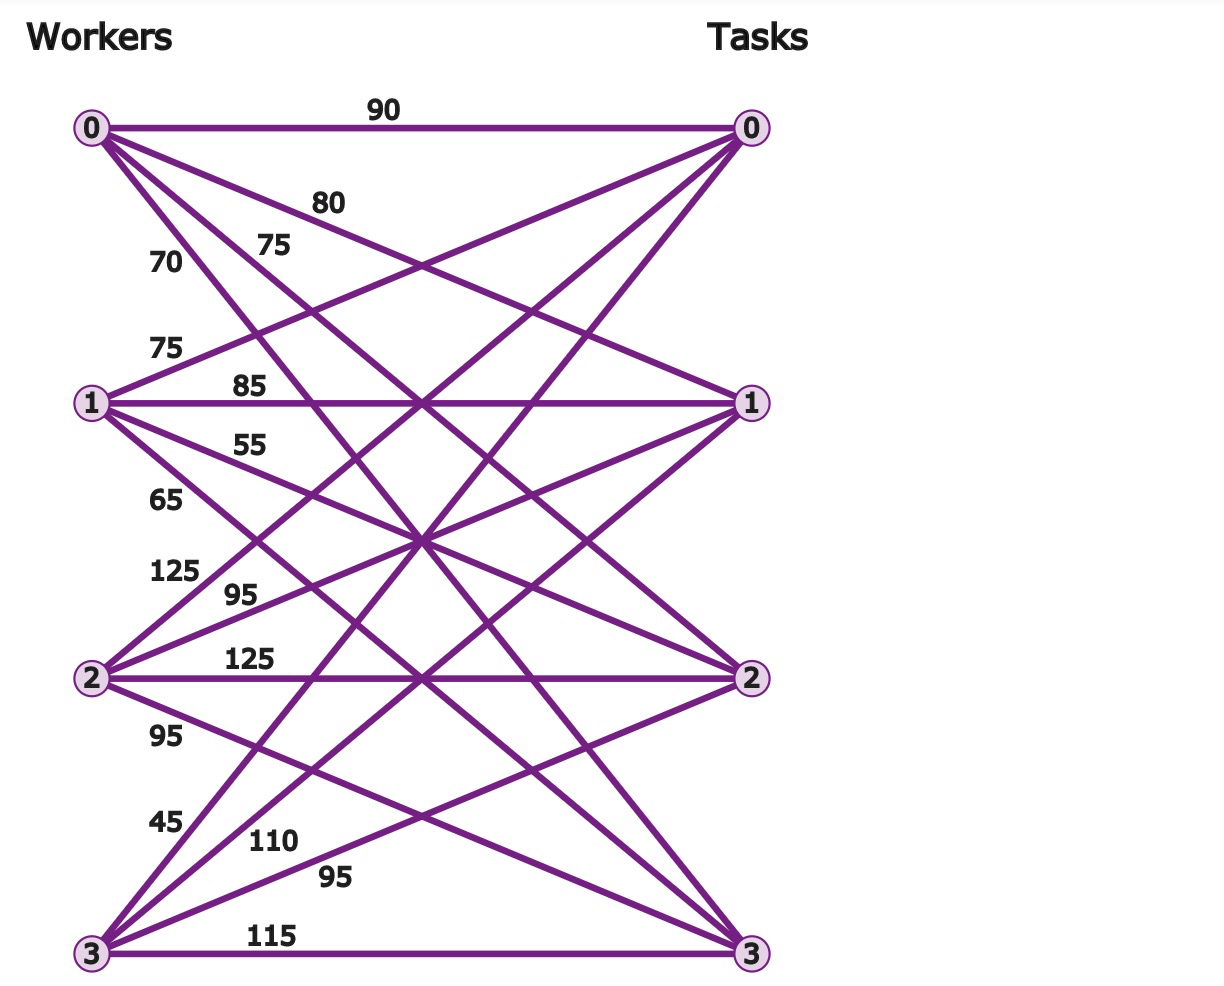

In [2]:
# !pip install ortools

In [3]:
import ortools

- 5명의 작업자와 4개의 작업간의 비용 테이블
- 중복 배정을 하지 않으므로, 한 명의 작업자는 작업을 배정받지 못한다
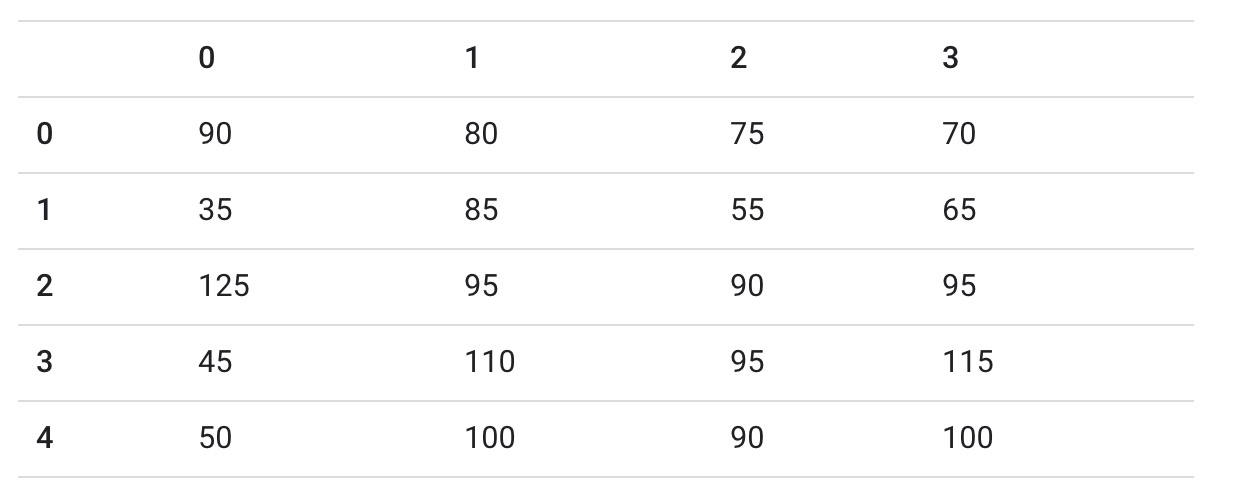

## MIP 를 사용하는 방법

In [4]:
from ortools.linear_solver import pywraplp

# Data
costs = [
    [90, 80, 75, 70],
    [35, 85, 55, 65],
    [125, 95, 90, 95],
    [45, 110, 95, 115],
    [50, 100, 90, 100],
]
num_workers = len(costs)
num_tasks = len(costs[0])

# Solver
# Create the mip solver with the CBC backend.
solver = pywraplp.Solver.CreateSolver('assignment_mip', 'CBC')


# 변수 정의
# x[i, j]는 0, 1을 가질 수 있으며, 작업자 i가 업무 j를 배정하면 1을 기록한다
x = {}
for i in range(num_workers):
    for j in range(num_tasks):
        x[i, j] = solver.IntVar(0, 1, '')

# 제약조건
# 작업자당 1개의 작업만 배정 (0일 수도 있다)
for i in range(num_workers):
    solver.Add(solver.Sum([x[i, j] for j in range(num_tasks)]) <= 1)

# 각 작업도 한 사람에게만 배정
for j in range(num_tasks):
    solver.Add(solver.Sum([x[i, j] for i in range(num_workers)]) == 1)

# 목적 함수 (전체 비용 합)
objective_terms = []
for i in range(num_workers):
    for j in range(num_tasks):
        objective_terms.append(costs[i][j] * x[i, j])

# 최소화 작업
solver.Minimize(solver.Sum(objective_terms))

# Solve
status = solver.Solve()

# 결과 보기
if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
    print('Total cost = ', solver.Objective().Value(), '\n')
    for i in range(num_workers):
        for j in range(num_tasks):
            # Test if x[i,j] is 1 (with tolerance for floating point arithmetic).
            if x[i, j].solution_value() > 0.5:
                print('Worker %d assigned to task %d.  Cost = %d' %
                      (i, j, costs[i][j]))

Total cost =  265.0 

Worker 0 assigned to task 3.  Cost = 70
Worker 1 assigned to task 2.  Cost = 55
Worker 2 assigned to task 1.  Cost = 95
Worker 3 assigned to task 0.  Cost = 45


## CP SAT를 사용하는 방법
- SAT: satisfiability

In [6]:
from ortools.sat.python import cp_model
# Data
costs = [
    [90, 80, 75, 70],
    [35, 85, 55, 65],
    [125, 95, 90, 95],
    [45, 110, 95, 115],
    [50, 100, 90, 100],
]
num_workers = len(costs)
num_tasks = len(costs[0])

# 모델
model = cp_model.CpModel()

# 변수
x = []
for i in range(num_workers):
    t = []
    for j in range(num_tasks):
        t.append(model.NewBoolVar('x[%i,%i]' % (i, j)))
    x.append(t)

# 제약 조건
# 작업자 조건
for i in range(num_workers):
    model.Add(sum(x[i][j] for j in range(num_tasks)) <= 1)

# 업무 조건
for j in range(num_tasks):
    model.Add(sum(x[i][j] for i in range(num_workers)) == 1)

# 목적 함수
objective_terms = []
for i in range(num_workers):
    for j in range(num_tasks):
        objective_terms.append(costs[i][j] * x[i][j])
model.Minimize(sum(objective_terms))

# Solve
solver = cp_model.CpSolver()
status = solver.Solve(model)

# 결과 출력
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print('Total cost = %i' % solver.ObjectiveValue())
    print()
    for i in range(num_workers):
        for j in range(num_tasks):
            if solver.BooleanValue(x[i][j]):
                print('Worker ', i, ' assigned to task ', j, '  Cost = ',
                      costs[i][j])
else:
    print('No solution found.')


Total cost = 265

Worker  0  assigned to task  3   Cost =  70
Worker  1  assigned to task  2   Cost =  55
Worker  2  assigned to task  1   Cost =  95
Worker  3  assigned to task  0   Cost =  45


# 팀별로 작업자가 구성되는 경우
- 총 6명의 작업자가 두개의 팀으로 나뉘어 있고 각 팀은 2개의 작업만 수행할 수 있는 경우
 -  team1 = [0, 2, 4]
 -  team2 = [1, 3, 5]
 -  team_max = 2

In [15]:
from ortools.linear_solver import pywraplp

solver = pywraplp.Solver('SolveAssignmentProblemMIP',
                       pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

cost = [[90, 76, 75, 70],
      [35, 85, 55, 65],
      [125, 95, 90, 105],
      [45, 110, 95, 115],
      [60, 105, 80, 75],
      [45, 65, 110, 95]]

team1 = [0, 2, 4]
team2 = [1, 3, 5]
team_max = 2

num_workers = len(cost)
num_tasks = len(cost[1])
x = {}

# 작업자- 작업 사이에 하나의 변수를 정의, 작업자: 0~5, 작업: 0~3
for i in range(num_workers):
  for j in range(num_tasks):
    x[i, j] = solver.BoolVar('x[%i,%i]' % (i, j))

# 목적 함수 (1로 배정된 경우의 합)
solver.Minimize(solver.Sum([cost[i][j] * x[i,j] for i in range(num_workers)
                                              for j in range(num_tasks)]))

# 작업자 제한 조건
for i in range(num_workers):
  solver.Add(solver.Sum([x[i, j] for j in range(num_tasks)]) <= 1)

# 작업 제한 조건
for j in range(num_tasks):
  solver.Add(solver.Sum([x[i, j] for i in range(num_workers)]) == 1)

# 각 팀별로 2개의 작업을 수행
solver.Add(solver.Sum([x[i, j] for i in team1 for j in range(num_tasks)]) <= team_max)
solver.Add(solver.Sum([x[i, j] for i in team2 for j in range(num_tasks)]) <= team_max)
sol = solver.Solve()

print('Total cost = ', solver.Objective().Value())
print()
for i in range(num_workers):
  for j in range(num_tasks):
    if x[i, j].solution_value() > 0:
      print('Worker %d assigned to task %d.  Cost = %d' % (
          i, j, cost[i][j]))

Total cost =  250.0

Worker 0 assigned to task 2.  Cost = 75
Worker 1 assigned to task 0.  Cost = 35
Worker 4 assigned to task 3.  Cost = 75
Worker 5 assigned to task 1.  Cost = 65


# 시간 제약이 추가된 경우
- 예를 들어 작업당 소요시간이 있고 개인별로 일정 시간 이상 작업을 할 수 없는 경우

## CP-SAT을 사용하는 경우

In [2]:
from ortools.sat.python import cp_model
import time
import numpy as np

model = cp_model.CpModel()

start = time.time()
# 작업자 i가 작업 j를 수행하는데 필요한 비용
cost = [[90, 76, 75, 70, 50, 74, 12, 68],
      [35, 85, 55, 65, 48, 101, 70, 83],
      [125, 95, 90, 105, 59, 120, 36, 73],
      [45, 110, 95, 115, 104, 83, 37, 71],
      [60, 105, 80, 75, 59, 62, 93, 88],
      [45, 65, 110, 95, 47, 31, 81, 34],
      [38, 51, 107, 41, 69, 99, 115, 48],
      [47, 85, 57, 71, 92, 77, 109, 36],
      [39, 63, 97, 49, 118, 56, 92, 61],
      [47, 101, 71, 60, 88, 109, 52, 90]]

# 각 작업의 소요시간
sizes = [10, 7, 3, 12, 15, 4, 11, 5]

# 한 작업자가 수행할 수 있는 최대 작업 시간 한계
total_size_max = 15
num_workers = len(cost)
num_tasks = len(cost[1])

# 변수
x = []
for i in range(num_workers):
  t = []
  for j in range(num_tasks):
    t.append(model.NewIntVar(0, 1, "x[%i,%i]" % (i, j)))
  x.append(t)
x_array = [x[i][j] for i in range(num_workers) for j in range(num_tasks)]

# 제한

# 각 작업은 하나 이상의 작업자에게 배정된다.
[model.Add(sum(x[i][j] for i in range(num_workers)) >= 1)
             for j in range(num_tasks)]

# 각 작업자의 작업시간 한계
[model.Add(sum(sizes[j] * x[i][j] for j in range(num_tasks)) <= total_size_max)
for i in range(num_workers)]
model.Minimize(sum([np.dot(x_row, cost_row) for (x_row, cost_row) in zip(x, cost)]))
solver = cp_model.CpSolver()
status = solver.Solve(model)

if status == cp_model.OPTIMAL:
  print('Minimum cost = %i' % solver.ObjectiveValue())
  print()

for i in range(num_workers):
  for j in range(num_tasks):
    if solver.Value(x[i][j]) == 1:
      print('Worker ', i, ' assigned to task ', j, '  Cost = ', cost[i][j])
print()
end = time.time()
print("Time = ", round(end - start, 4), "seconds")


Minimum cost = 326

Worker  0  assigned to task  6   Cost =  12
Worker  1  assigned to task  0   Cost =  35
Worker  1  assigned to task  2   Cost =  55
Worker  4  assigned to task  4   Cost =  59
Worker  5  assigned to task  5   Cost =  31
Worker  5  assigned to task  7   Cost =  34
Worker  6  assigned to task  1   Cost =  51
Worker  8  assigned to task  3   Cost =  49

Time =  4.5889 seconds


## MIP를 사용하는 경우

In [4]:
import time
from ortools.linear_solver import pywraplp

def main():
  solver = pywraplp.Solver('SolveAssignmentProblem',
                           pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

  start = time.time()
  cost = [[90, 76, 75, 70, 50, 74, 12, 68],
          [35, 85, 55, 65, 48, 101, 70, 83],
          [125, 95, 90, 105, 59, 120, 36, 73],
          [45, 110, 95, 115, 104, 83, 37, 71],
          [60, 105, 80, 75, 59, 62, 93, 88],
          [45, 65, 110, 95, 47, 31, 81, 34],
          [38, 51, 107, 41, 69, 99, 115, 48],
          [47, 85, 57, 71, 92, 77, 109, 36],
          [39, 63, 97, 49, 118, 56, 92, 61],
          [47, 101, 71, 60, 88, 109, 52, 90]]

  task_sizes = [10, 7, 3, 12, 15, 4, 11, 5]

  # 개인별 최대 작업 시간
  total_size_max = 15
  num_workers = len(cost)
  num_tasks = len(cost[1])
  # Variables
  x = {}

  for i in range(num_workers):
    for j in range(num_tasks):
      x[i, j] = solver.IntVar(0, 1, 'x[%i,%i]' % (i, j))

  # 제한
  # 개인별 작업 시간 제하 < total_size_max.

  for i in range(num_workers):
    solver.Add(solver.Sum([task_sizes[j] * x[i, j] for j in range(num_tasks)]) <= total_size_max)

  # 각 작업은 한 명 이상에게 배정되어야 한다

  for j in range(num_tasks):
    solver.Add(solver.Sum([x[i, j] for i in range(num_workers)]) >= 1)

  solver.Minimize(solver.Sum([cost[i][j] * x[i,j] for i in range(num_workers)
                                                  for j in range(num_tasks)]))
  sol = solver.Solve()

  print('Minimum cost = ', solver.Objective().Value())
  print()
  for i in range(num_workers):
    for j in range(num_tasks):
      if x[i, j].solution_value() > 0:
        print('Worker', i,' assigned to task', j, '  Cost = ', cost[i][j])
  print()
  end = time.time()
  print("Time = ", round(end - start, 4), "seconds")
if __name__ == '__main__':
  main()

Minimum cost =  326.0

Worker 0  assigned to task 6   Cost =  12
Worker 1  assigned to task 0   Cost =  35
Worker 1  assigned to task 2   Cost =  55
Worker 4  assigned to task 4   Cost =  59
Worker 5  assigned to task 5   Cost =  31
Worker 5  assigned to task 7   Cost =  34
Worker 6  assigned to task 1   Cost =  51
Worker 8  assigned to task 3   Cost =  49

Time =  0.0261 seconds
